# Solution to programming exercises week 3
INF2310 spring 2017

## Task 3

In this task, we will implement scaling, translation, and rotation transforms, both using the forward transform and the backward transform.

For both transforms, we compute a new set of coordinates using an affine transformation.

For a forward transformation, we traverse the original image, get a value at that original location, and use the new set of coordinates to define the location in the transformed image where the value is put.

For a backward transformation, we traverse the transformed image, and use the new coordinates to decide where from, in the original image, we shall get the values.

First, we read some image, and display it.

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

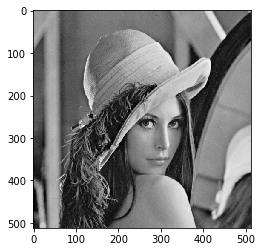

In [2]:
im = cv2.imread('../../assets/images/lena.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(im, cmap='gray')

Now, in order to see the effects of the transform a bit better, let us create a white frame around the image.

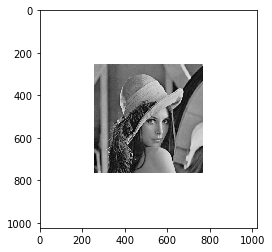

In [3]:
framesize = 256
y_start = framesize
x_start = framesize
y_end = y_start + im.shape[1]
x_end = x_start + im.shape[0]

framed_im = 255*np.ones((2*framesize + im.shape[0], 2*framesize + im.shape[1]))
framed_im[x_start:x_end, y_start:y_end] = im

plt.imshow(framed_im, cmap='gray')

### Forward transform

First, we implement the method that will do the forward affine transform. Given parameters for an affine transform (a matrix A, and a vector b), the method will transform an input image centered at the image center.

In [4]:
def forward_transform(image, A, b, x_start=None, x_end=None, y_start=None, y_end=None):
    """
    Compute a forward affine transform of the input image.
    
    Args:
        image: 2d input image (grayscale)
        A: Transformation matrix (2x2)
        b: Transformation bias (2x1)
        x_start: Optional vertical start index (if image is framed)
        x_end: Optional vertical end index (if image is framed)
        y_start: Optional horizontal start index (if image is framed)
        y_end: Optional horizontal end index (if image is framed)
    Returns:
        transformed_image: result after transform, same shape as image
    """
    if x_start is None:
        x_start = 0
    if y_start is None:
        y_start = 0
    if x_end is None:
        x_end = image[0]
    if y_end is None:
        y_end = image[1]
        
    x_center = int(np.round((x_start + x_end)/2))
    y_center = int(np.round((y_start + y_end)/2))
    transformed_image = 255*np.ones_like(image)
    
    for x in range(x_start, x_end):
        for y in range(y_start, y_end):
            # Get coordinates
            [x_new, y_new] = np.dot(A, np.array([x - x_center, y - y_center])) + b
            x_new = int(np.round(x_new))
            y_new = int(np.round(y_new))
            # Get value
            transformed_image[x_new + x_center, y_new + y_center] = image[x, y]
    return transformed_image

#### Scaling
Here, we define the parameters for the scaling transform, and then try them in our forward transform function.

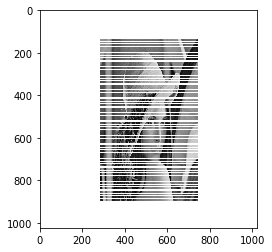

In [5]:
scale_x = 1.5
scale_y = 0.9

scale_mat = np.array([[scale_x, 0], [0, scale_y]])
scale_bias = np.array([0, 0])

forward_scale_image = forward_transform(framed_im, scale_mat, scale_bias, x_start, x_end, y_start, y_end)

plt.imshow(forward_scale_image, cmap='gray', interpolation='none')

#### Translation
Here, we define the parameters for the translation transform

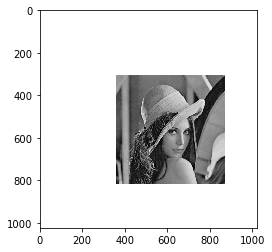

In [6]:
delta_x = 50
delta_y = 100

translation_mat = np.identity(2) # [[1, 0], [0, 1]]
translation_bias = np.array([delta_x, delta_y])

forward_translation_image = forward_transform(framed_im, translation_mat, translation_bias,
                                              x_start, x_end, y_start, y_end)

plt.imshow(forward_translation_image, cmap='gray', interpolation='none')

#### Rotation
Here, we define the parameters for the rotation transform.

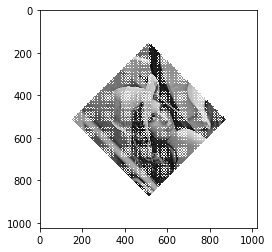

In [7]:
theta = np.pi / 4

rotation_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotation_bias = np.array([0, 0])

forward_rotation_image = forward_transform(framed_im, rotation_mat, rotation_bias,
                                           x_start, x_end, y_start, y_end)

plt.imshow(forward_rotation_image, cmap='gray', interpolation='none')

### Backward transform

As is evident, the results from forward transform is not ideal, as there are missing values, especially in the rotation and scaling case. Below, we will implement the backward transform, both with and without bilinear interpolation.

In [8]:
def backward_transform(image, A, b, bilinear=False, x_start=None, x_end=None, y_start=None, y_end=None):
    """
    Compute a forward affine transform of the input image.
    
    Args:
        image: 2d input image (grayscale)
        A: Transformation matrix (2x2)
        b: Transformation bias (2x1)
        bilinear: Flag to indicate if we want to do the transformation with or without bilinear interpolation
        x_start: Optional vertical start index (if image is framed)
        x_end: Optional vertical end index (if image is framed)
        y_start: Optional horizontal start index (if image is framed)
        y_end: Optional horizontal end index (if image is framed)
    Returns:
        transformed_image: result after transform, same shape as image
    """
    if x_start is None:
        x_start = 0
    if y_start is None:
        y_start = 0
    if x_end is None:
        x_end = image.shape[0]
    if y_end is None:
        y_end = image.shape[1]
        
    x_center = int(np.round((x_start + x_end)/2))
    y_center = int(np.round((y_start + y_end)/2))
    transformed_image = 255*np.ones_like(image)
    
    #for x in range(x_start, x_end):
    #    for y in range(y_start, y_end):
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            # Get coordinates
            [x_new, y_new] = np.dot(A, np.array([x - x_center, y - y_center])) + b
            
            
            
            if bilinear:
                x_new = x_new + x_center
                y_new = y_new + y_center
                
                x1 = int(np.floor(x_new))
                x2 = int(np.ceil(x_new))
                y1 = int(np.floor(y_new))
                y2 = int(np.ceil(y_new))
                if x1 == x2 or y1 == y2:
                    x2 = x1 + 1
                    y2 = y2 + 1
                    
                if (x1 < 0 or x2 < 0 or x1 >= image.shape[0] or x2 >= image.shape[0] or
                        y1 < 0 or y2 < 0 or y1 >= image.shape[1] or y2 >= image.shape[1]):
                    continue
                
                h_x_y1 = ((x2 - x_new)*image[x1, y1] + (x_new - x1)*image[x1, y2]) / (x2 - x1)
                h_x_y2 = ((x2 - x_new)*image[x2, y1] + (x_new - x1)*image[x2, y2]) / (x2 - x1)
                g_x_y = ((y2 - y_new)*h_x_y1 + (y_new - y1)*h_x_y2) / (y2 - y1)
                
                transformed_image[x, y] = g_x_y
            else:
                x_new = int(np.round(x_new))
                y_new = int(np.round(y_new))
                
                if (x_new + x_center < 0 or x_new + x_center >= image.shape[0] or
                        y_new + y_center < 0 or y_new + y_center >= image.shape[1]):
                    continue
                
                transformed_image[x, y] = image[x_new + x_center, y_new + y_center]
    
    return transformed_image

#### Scaling
Here, we define the parameters for the scaling transform, and then try them in our backward transform function. First without bilinear interpolation.

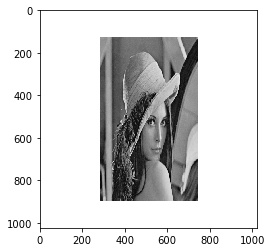

In [9]:
scale_x = 1.5
scale_y = 0.9

# Invert the scaling parameters since we are doing backward transform
scale_x = 1 / scale_x
scale_y = 1 / scale_y

scale_mat = np.array([[scale_x, 0], [0, scale_y]])
scale_bias = np.array([0, 0])

backward_scale_image = backward_transform(framed_im, scale_mat, scale_bias, False, x_start, x_end, y_start, y_end)

plt.imshow(backward_scale_image, cmap='gray', interpolation='none')

Then, with bilinear interpolation.

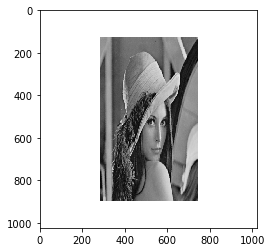

In [10]:
backward_interp_scale_image = backward_transform(framed_im, scale_mat, scale_bias, True, x_start, x_end, y_start, y_end)

plt.imshow(backward_interp_scale_image, cmap='gray', interpolation='none')

#### Translation
Here, we define the parameters for the translation transform.

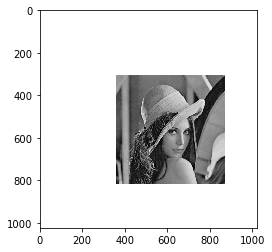

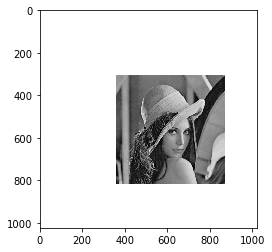

In [11]:
delta_x = 50
delta_y = 100

# Negate the shift since we are doing backward translation
delta_x = -delta_x
delta_y = -delta_y

translation_mat = np.identity(2) # [[1, 0], [0, 1]]
translation_bias = np.array([delta_x, delta_y])

# Without interpolation
backward_translation_image = backward_transform(framed_im, translation_mat, translation_bias, False,
                                                x_start, x_end, y_start, y_end)

plt.figure(0)
plt.imshow(backward_translation_image, cmap='gray', interpolation='none')

# With interpolation
backward_interp_translation_image = backward_transform(framed_im, translation_mat, translation_bias, True,
                                                       x_start, x_end, y_start, y_end)

plt.figure(1)
plt.imshow(backward_interp_translation_image, cmap='gray', interpolation='none')


#### Rotation
Here, we define the parameters for the rotation transform.

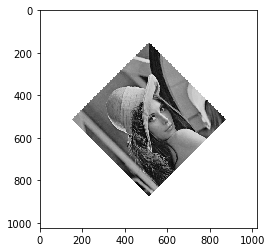

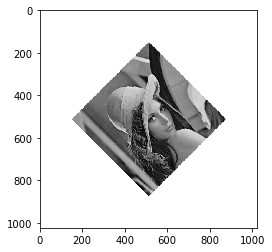

In [12]:
theta = np.pi / 4

# Negate the angle since we are doing backward transform
theta = -theta

rotation_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
rotation_bias = np.array([0, 0])

# Without interpolation
backward_rotation_image = backward_transform(framed_im, rotation_mat, rotation_bias, False,
                                             x_start, x_end, y_start, y_end)

plt.figure(0)
plt.imshow(backward_rotation_image, cmap='gray', interpolation='none')

# With interpolation
backward_interp_rotation_image = backward_transform(framed_im, rotation_mat, rotation_bias, True,
                                                    x_start, x_end, y_start, y_end)

plt.figure(1)
plt.imshow(backward_interp_rotation_image, cmap='gray', interpolation='none')

## Task 5

In this task, we are given three input points 

$$
    x_i =
    \left(
    \begin{array}{c}
        x_{i1} \\
        x_{i2}
    \end{array}
    \right),
    \quad i = 1, 2, 3,
$$

and three output points

$$
    y_i =
    \left(
    \begin{array}{c}
        y_{i1} \\
        y_{i2}
    \end{array}
    \right),
    \quad i = 1, 2, 3.
$$

The output points are the result from an affine transformation

$$
    y_i = Ax_i + b, \quad i = 1, 2, 3
$$

where

$$
    A =
    \left(
    \begin{array}{cc}
        a_{11} & a_{12} \\
        a_{21} & a_{22}
    \end{array}
    \right),
    \quad
    b = 
    \left(
    \begin{array}{c}
        b_{1} \\
        b_{2}
    \end{array}
    \right).
$$

The task is then to compose a system of equations and solve it for *A* and *b*. Note that the notation used here may differ from the one in lecture slides.

#### Solution

First, we will join *A* and *b* to form a matrix *M* containing all the unknowns

$$
    M = 
    \left(
    \begin{array}{ccc}
        a_{11} & a_{12} & b_1 \\
        a_{21} & a_{22} & b_2
    \end{array}
    \right).
$$

Then, we set the input points as rows in a new matrix together with a column of ones at the right

$$
    X = 
    \left(
    \begin{array}{ccc}
        x_{11} & x_{12} & 1 \\
        x_{21} & x_{22} & 1 \\
        x_{31} & x_{32} & 1
    \end{array}
    \right).
$$

The output points will be arranged in a similar fashion

$$
    Y = 
    \left(
    \begin{array}{ccc}
        y_{11} & y_{12} \\
        y_{21} & y_{22} \\
        y_{31} & y_{32}
    \end{array}
    \right).
$$

With this, we can arrange one system of equations that we need to solve

$$
    Y = X M^\intercal.
$$

It is strongly encouraged that you check this, and understand how it works.

Now, if *X* had been invertible, we could have inverted it and left-multiplied both sides with this inverse. In general, it is not, so we will use a pseudo-inverse instead. We will choose one that minimizes the *L2* norm

$$
    ||Y - XM^\intercal||_2
$$

and the solution we find is called the *least squares solution*. If $X$ is invertible, this will be eqivalent to the "normal matrix inverse" solution of the system.

Note that this is probably outside the scope of this course, and thus I will not bother you with a lengthy derivation. In stead, for those who are interested, look up least squares and Moore-Penrose pseudoinverse. Systems on this form appear "all the time" in numerical mathematics / statistics, so if you are interested in these kind of stuff, it will be worth your while to try to understand it.

Anyways... multiply both sides with the transpose of *X*

$$
    X^\intercal Y = X^\intercal X M^\intercal,
$$

this system is called the *normal equations*. The matrix $X^\intercal X$ is *positive semi-definite*, and we can invert it such that our final solution is

$$
    M^\intercal = (X^\intercal X)^{-1} X^\intercal Y.
$$

I will now put up an example

In [13]:
# Input coordinates
x_1 = np.array([10, 10])
x_2 = np.array([100, 100])
x_3 = np.array([200, 100])

# Output coordinates (corresponding to a shift in the x-direction of 20 pixels)
y_1 = np.array([30, 10])
y_2 = np.array([120, 100])
y_3 = np.array([220, 100])

# Set up X and Y
X = np.vstack((x_1, x_2, x_3))
X = np.concatenate((X, np.ones((3, 1))), axis=1)
print("X = \n", X)

Y = np.vstack((y_1, y_2, y_3))
print("Y = \n", Y)

X = 
 [[  10.   10.    1.]
 [ 100.  100.    1.]
 [ 200.  100.    1.]]
Y = 
 [[ 30  10]
 [120 100]
 [220 100]]


In [14]:
# Compute M
xtx = np.dot(X.T, X)
xtx_inv = np.linalg.inv(xtx)

my_M = np.dot(np.dot(xtx_inv, X.T), Y).T

# Extract A and b
my_A = my_M[:, :2]
my_b = my_M[:, -1]

print("M = \n", my_M)
print("A = \n", my_A)
print("b = \n", my_b)

M = 
 [[  1.00000000e+00  -3.12250226e-16   2.00000000e+01]
 [  2.40779618e-15   1.00000000e+00   1.68753900e-14]]
A = 
 [[  1.00000000e+00  -3.12250226e-16]
 [  2.40779618e-15   1.00000000e+00]]
b = 
 [  2.00000000e+01   1.68753900e-14]


Let us check that our solution makes sense

In [15]:
test_y = np.dot(X, my_M.T)
print(test_y)
print(test_y - Y)

[[  30.   10.]
 [ 120.  100.]
 [ 220.  100.]]
[[  3.90798505e-14   3.90798505e-14]
 [  3.97903932e-13   2.13162821e-13]
 [  8.24229573e-13   4.54747351e-13]]
